# XWTs_in_IFS-Model.ipynb

#!/usr/bin/env python
'''File name: XWTs_in_IFS-Model.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.05.2020
    Date last modified: 04.05.2020

    ############################################################## 
    Purpos:

    Load XWTs centroids that were created by running:
    /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/XWTing/XWTs_search_ERA5.py

    1) Read the nescessary variables from the model in which XWTs should be searched for
    2) Bring the centroids and the model data to the common coarser resolution grid
    3) Preprocess the model data
    3) Calculate Eucledian Distances for each day
    4) Save the data

'''

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import EucledianDistance

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)


### Program Setup

In [4]:
Season='Annual' # ['AMJJAS', 'ONDJFM']

DW_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
sSubregionPR='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/' #+Regions[sRegion]

SelVar = np.array([['RH2AVG','MF2AVG','V850'],
         ['RH500','SLPAVG','V10AVG'],
         ['MR2AVG','SLPAVG','WSPD10'],
         ['T2MIN','U10AVG','U500'],
         ['RH500','T2AVG','T500'],
         ['MF2AVG','PWAVG','V200'],
         ['T2MIN','T500','WSPD500'],
         ['RH2AVG','V500','WSPD200']])


E5Vars=['CAPE','CIN','LCL','LFC','MF2AVG','MF500','MF850','MR2AVG','MR500','MR850','PWAVG','RH2AVG',\
        'RH500','RH850','SLPAVG','T2AVG','T2MAX','T2MIN','T500','T850','U10AVG','U200','U500','U850',\
        'V10AVG','V200','V500','V850','WSPD10','WSPD200','WSPD500','WSPD850','Z500']
IFSVars = ['CAPE','CIN','LCL','LFC','MF2AVG','FLX500','FLX850','Q2','Q500','Q850','PWAVG','RH2',\
           'RH500','RH850','SLPAVG','T2AVG','T2MAX','T2MIN','T500','T850','U10','U200','U500','U850',\
           'V10','V200','V500','V850','UV10','UV200','UV500','UV850','Z500']

sPlotDir='/glade/u/home/prein/papers/Extreme-WTs-US/plots/IFS_XWTs/'# +str(iNrOfExtremes)+'_Events/'
sDataDir='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_IFS/'

Nr_XWTs = [4,4,10,8,4,4,15,8]

YYYY_stamp = '2001-2019'
Season = 'Annual'
FireObs = 'MODIS'
REANAL = 'ERA5'

In [11]:
Season='Annual' # ['AMJJAS', 'ONDJFM']
# Read IFS
dStartDayIFS=datetime.datetime(2016, 1, 1,0)
dStopDayIFS=datetime.datetime(2020, 9, 30,23)
IFS_time = pd.date_range(dStartDayIFS, end=dStopDayIFS, freq='d')
IFS_timeMM = pd.date_range(dStartDayIFS, end=dStopDayIFS, freq='m')
IFSYYYY=np.unique(IFS_time.year)

# RE=7
# Data_All={}
# for re in range(len(DW_Regions)):
#     Region=DW_Regions[re]
#     print('    process '+Region)

#     Variables=SelVar[re,:]
#     ExtrNR = Nr_XWTs[re]
        
#     s = "-"; VarString=s.join(Variables)
    
#     XWTdata='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/'+'Clusters'+str(ExtrNR)+'_'+Region+'_'+YYYY_stamp+'_'+VarString+'_'+Season+'_'+FireObs+'_'+REANAL
#     sClusterSave=sDataDir+'Clusters'+str(ExtrNR)+'_'+Region+'_'+YYYY_stamp+'_'+VarString+'_'+Season+'_'+FireObs+'_'+REANAL
    
#     # ### Load the centroids and shape file
#     print('    Restore: '+XWTdata)
#     with open(XWTdata, 'rb') as handle:
#         npzfile = pickle.load(handle)
#     XWTclusters=npzfile['grClustersFin']['Full']
#     XWTlat=npzfile['LatWT']
#     XWTlon=npzfile['LonWT']
#     XWTtime=npzfile['rgdTime']
#     SpatialSmoothing=npzfile['SpatialSmoothing']
    
#     print('        Load shapefile')
#     sf = shp.Reader(sSubregionPR+Region)
#     df = read_shapefile(sf)
#     for sf in range(df.shape[0]):
#         ctr = df['coords'][sf]
#         if len(ctr) > 10000:
#             ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
#         else:
#             ctr=np.array(ctr)
#         grPRregion=mplPath.Path(ctr)
    
#     # ### Read IFS data
#     ncid=Dataset('/glade/campaign/mmm/c3we/prein/IFS/T2AVG/T2AVG_201601_daymean.nc', mode='r')
#     IFSLat=np.squeeze(ncid.variables['latitude'][:])
#     IFSLon=np.squeeze(ncid.variables['longitude'][:])
#     ncid.close()
#     IFSLon[IFSLon>180]=IFSLon[IFSLon>180]-360
#     IFSLon2D, IFSLat2D = np.meshgrid(IFSLon, IFSLat)
    
# #     rgrGridCells=[(IFSLon2D.ravel()[ii],IFSLat2D.ravel()[ii]) for ii in range(len(IFSLat2D.ravel()))]
# #     rgrSRactP=np.zeros((IFSLat2D.shape[0]*IFSLat2D.shape[1]))
# #     TMP=np.array(grPRregion.contains_points(rgrGridCells))
# #     rgrSRactP[TMP == 1]=1
# #     rgrSRactP=np.reshape(rgrSRactP, (IFSLat2D.shape[0], IFSLat2D.shape[1]))
    
#     # get grid cells that cover the centroid
#     N_XWT=np.max(XWTlat)
#     S_XWT=np.min(XWTlat)
#     E_XWT=np.max(XWTlon)
#     W_XWT=np.min(XWTlon)
    
    
#     # ### Bring data to same grid
#     if XWTlat.shape[0]*XWTlon.shape[0] > IFSLat2D.shape[0]*IFSLat2D.shape[1]:
#         # we remap the centroids to the model grid
        
#         # ERA-20C area that contains this region
#         IFS_W=np.where(np.max((IFSLon2D <= W_XWT), axis=0) == 1)[0][-1]+1 #-1
#         IFS_E=np.where(np.max((IFSLon2D <= E_XWT), axis=0) == 1)[0][-1]+1
#         IFS_S=np.where(np.max((IFSLat2D <= S_XWT), axis=1) == 1)[0][0]-1
#         IFS_N=np.where(np.max((IFSLat2D <= N_XWT), axis=1) == 1)[0][0] #-1

#         # # Cut out Lat and Lon
#         IFSLon2D=IFSLon2D[IFS_N:IFS_S,IFS_W:IFS_E]
#         IFSLat2D=IFSLat2D[IFS_N:IFS_S,IFS_W:IFS_E]
        
#         Clusters=np.reshape(XWTclusters[0],(XWTclusters[0].shape[0],XWTlat.shape[0],XWTlon.shape[1],len(Variables)))
#         RemappedClusters=np.zeros((Clusters.shape[0],IFSLat2D.shape[0],IFSLat2D.shape[1],Clusters.shape[3]))
        
#         [Y,X]=(XWTlon, XWTlat)
#         [Yi,Xi]=(IFSLon2D,IFSLat2D)
#         xy=np.zeros([X.shape[0]*X.shape[1],2])
#         xy[:,0]=Y.flatten()
#         xy[:,1]=X.flatten()
#         uv=np.zeros([Xi.shape[0]*Xi.shape[1],2])
#         uv[:,0]=Yi.flatten()
#         uv[:,1]=Xi.flatten()
#         #Computed once and for all !
#         vtx, wts = interp_weights(xy, uv)
        
#         for cl in range(Clusters.shape[0]):
#             for va in range(len(Variables)):
#                 values=Clusters[cl,:,:,va]
#                 valuesi=interpolate(values.flatten(), vtx, wts)
#                 RemappedClusters[cl,:,:,va]=valuesi.reshape(Xi.shape[0],Xi.shape[1])
#         # we have to renormalize the clusters
#         Normalized=(RemappedClusters-np.mean(RemappedClusters, axis=(1,2))[:,None,None,:])
#         Normalized=Normalized/np.std(Normalized, axis=(1,2))[:,None,None,:]
#         ClusterPrepared=(np.reshape(Normalized, (Normalized.shape[0],Normalized.shape[1]*Normalized.shape[2]*Normalized.shape[3])),XWTclusters[1])
#     else:
#         # we remap the data to the resolution of the centroids
#         # ERA-20C area that contains this region
#         IFS_W=np.where(np.max((IFSLon2D <= W_XWT), axis=0) == 1)[0][-1]-10 #-1
#         IFS_E=np.where(np.max((IFSLon2D <= E_XWT), axis=0) == 1)[0][-1]+10
#         IFS_S=np.where(np.max((IFSLat2D <= S_XWT), axis=1) == 1)[0][0]+10
#         IFS_N=np.where(np.max((IFSLat2D <= N_XWT), axis=1) == 1)[0][0]-10 #-1

#         # # Cut out Lat and Lon
#         IFSLon2D=IFSLon2D[IFS_N:IFS_S,IFS_W:IFS_E]
#         IFSLat2D=IFSLat2D[IFS_N:IFS_S,IFS_W:IFS_E]
    
#     IFS_DATA=np.zeros((len(IFS_time),IFSLon2D.shape[0],IFSLon2D.shape[1], len(Variables))); IFS_DATA[:]=np.nan
#     for mm in range(len(IFS_timeMM)):
#         DDact=((IFS_time.year == IFS_timeMM[mm].year) & (IFS_time.month == IFS_timeMM[mm].month))
#         for va in range(len(Variables)):
#             VARact = IFSVars[E5Vars.index(Variables[va])]
#             FILE=glob.glob('/glade/campaign/mmm/c3we/prein/IFS/'+VARact+'/'+VARact+'_'+str(IFS_timeMM[mm].year)+str(IFS_timeMM[mm].month).zfill(2)+'_daymean.nc')[0]
#             ncid=Dataset(FILE, mode='r') # open the netcdf file
#             IFS_DATA[DDact,:,:,va]=np.squeeze(ncid.variables[VARact][:,IFS_N:IFS_S,IFS_W:IFS_E])
#             ncid.close()
            
#     # smooth the data
#     SmoothSigma = 2
#     IFS_DATASM = gaussian_filter(IFS_DATA[:,:,:,:], sigma=(0,SmoothSigma,SmoothSigma,0))

#     if XWTlat.shape[0]*XWTlon.shape[0] <= IFSLat2D.shape[0]*IFSLat2D.shape[1]:
#         # we remap the data to the resolution of the centroids
#         Clusters=np.reshape(XWTclusters[0],(XWTclusters[0].shape[0],XWTlat.shape[0],XWTlon.shape[1],len(Variables)))
#         RemappedIFS=np.zeros((IFS_DATA.shape[0],XWTlat.shape[0],XWTlon.shape[1],IFS_DATA.shape[3]))
        
#         [Y,X]=(IFSLon2D,IFSLat2D)
#         [Yi,Xi]=(XWTlon, XWTlat)
#         xy=np.zeros([X.shape[0]*X.shape[1],2])
#         xy[:,0]=Y.flatten()
#         xy[:,1]=X.flatten()
#         uv=np.zeros([Xi.shape[0]*Xi.shape[1],2])
#         uv[:,0]=Yi.flatten()
#         uv[:,1]=Xi.flatten()
#         #Computed once and for all !
#         vtx, wts = interp_weights(xy, uv)
        
#         for dd in range(IFS_DATA.shape[0]):
#             for va in range(IFS_DATA.shape[3]):
#                 values=IFS_DATASM[dd,:,:,va]
#                 valuesi=interpolate(values.flatten(), vtx, wts)
#                 RemappedIFS[dd,:,:,va]=valuesi.reshape(Xi.shape[0],Xi.shape[1])
#         # prepare the existing clusters
#         ClusterPrepared=(np.reshape(Clusters, (Clusters.shape[0],Clusters.shape[1]*Clusters.shape[2]*Clusters.shape[3])),Clusters[1])

#     DailyVarsEvalNorm=PreprocessWTdata(RemappedIFS,                  # WT data [time,lat,lon,var]
#                                RelAnnom=1,                     # calculate relative anomalies [1-yes; 0-no]
#                                SmoothSigma=SpatialSmoothing,   # Smoothing stddev (Gaussian smoothing)
#                                RemoveAnnualCycl=1,             # remove annual cycle [1-yes; 0-no]
#                                NormalizeData=1)                # normalize data [1-yes; 0-no]

#     EucledianDist, Correlation =EucledianDistance(DailyVarsEvalNorm,
#                                                   ClusterPrepared)
#     EucledianDist_orig=np.copy(EucledianDist)
#     EucledianDist=np.min(EucledianDist,axis=1)

#     EDspace=np.linspace(EucledianDist.min(),np.percentile(EucledianDist,0.2),100)
# #     ChangeInFr=np.zeros((len(EDspace)))
# #     RP=np.zeros((len(EDspace)))
# #     ClimLen=40

# #     for ed in range(len(EDspace)):
# #         TEST=(EucledianDist < EDspace[ed])
# #         ExtrFrY=float(np.sum(TEST))/len(IFSYYYY)
# #         ExpectedFrequency=np.cumsum(np.array([ExtrFrY]*len(IFSYYYY)))
# #         RP[ed]=ExtrFrY
# #         TEST=np.array([np.sum(TEST[IFS_time.year == IFSYYYY[yy]]) for yy in range(len(IFSYYYY))])
# #         TEST=np.cumsum(TEST, dtype=float)
    
# #         Ref=(TEST[ClimLen]-TEST[0])
# #         Cur=(TEST[-1]-TEST[-ClimLen])
# #         ChangeInFr[ed]=((Cur-Ref)/float(Ref))*100

# #     # In[37]:
# #     # calculate random chance
# #     try:
# #         RandomChance
# #     except:
# #         BSnr=1000
# #         RandomChance=np.zeros((len(RP),BSnr))
# #         for pe in range(len(RP)):
# #             NrOfEvents=(RP*len(IFSYYYY))[pe]
# #             for bs in range(BSnr):
# #                 RandomDays=np.sort(np.array([random.randint(0, len(IFSYYYY)-1) for ii in range(int(NrOfEvents))]))
# #                 RandRecord=np.zeros((len(IFSYYYY)))
# #                 for ii in range(len(RandomDays)):
# #                     RandRecord[RandomDays[ii]]=RandRecord[RandomDays[ii]]+1
# #                 Ref=np.sum(RandRecord[:ClimLen])
# #                 Cur=np.sum(RandRecord[-ClimLen:])
# #                 RandomChance[pe,bs]=((Cur-Ref)/float(Ref))*100

#     Data_reg={'EucledianDist_orig':EucledianDist_orig,
#               'IFS_time':IFS_time}
#     Data_All[Region]=Data_reg

# # Save the data
# afile = open(sDataDir+'IFS_XWTs_Eucledian-Distances.pkl', 'wb')
# pickle.dump(Data_All, afile)
# afile.close()

# Load the Eulirian distance data
file = open(sDataDir+'IFS_XWTs_Eucledian-Distances.pkl', 'rb')
DATA_ED = pickle.load(file)
file.close()


### Load VIIRS data

In [6]:
Data1 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/fire_archive_V1_7669.csv'
Data2 = '/glade/campaign/mmm/c3we/prein/observations/Fire-observations/FIRMS_VIIRS/fire_nrt_V1_7669.csv'

dStartDayPR=datetime.datetime(2016, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2020, 9, 30,23)
rgdTimeFIRMS_V = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

DATA1 = pd.read_csv(Data1)
DATA2 = pd.read_csv(Data2)

LAT_FV = np.append(np.array(DATA1['latitude']),np.array(DATA2['latitude']))
LON_FV = np.append(np.array(DATA1['longitude']),np.array(DATA2['longitude']))
DATE_FV = np.append(np.array(DATA1['acq_date']),np.array(DATA2['acq_date']))
AREA_FV = np.append(np.array(DATA1['scan'])*np.array(DATA1['track']),np.array(DATA2['scan'])*np.array(DATA2['track']))

# Cut out CA region
CA = ((LAT_FV >= 32) & (LAT_FV <= 42) & (LON_FV >= -125) & (LON_FV <=- 114))
LAT_FV = LAT_FV[CA]
LON_FV = LON_FV[CA]
DATE_FV = DATE_FV[CA]
AREA_FV = AREA_FV[CA]

FIRMSV_SRdata=np.zeros((len(rgdTimeFIRMS_V),len(DW_Regions))); FIRMSV_SRdata[:]=0
for sr in range(len(DW_Regions)):
    print('    process MTBS data for region '+DW_Regions[sr])
    sSubregionTMP=sSubregionPR+DW_Regions[sr]
    rgrGridCells=[(LON_FV.ravel()[ii],LAT_FV.ravel()[ii]) for ii in range(len(LON_FV.ravel()))]
    rgrSRactP=np.zeros((LON_FV.shape[0]))
    sf = shp.Reader(sSubregionTMP)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    DATE_SR = DATE_FV[TMP == 1]
    AREA_SR = AREA_FV[TMP == 1]
    DAYS_act = np.unique(DATE_SR)
    for dd in range(len(DAYS_act)):
        iDD = ((rgdTimeFIRMS_V.year == int(DAYS_act[dd][:4])) & (rgdTimeFIRMS_V.month == int(DAYS_act[dd][5:7])) & (rgdTimeFIRMS_V.day == int(DAYS_act[dd][8:10])))
        Events = (DAYS_act[dd] == DATE_SR)
        FIRMSV_SRdata[iDD,sr] = np.sum(AREA_SR[Events])

    process MTBS data for region Bay_Area
    process MTBS data for region Central_Coast
    process MTBS data for region LA
    process MTBS data for region Modoc
    process MTBS data for region Northeast
    process MTBS data for region San_Diego
    process MTBS data for region Siearas_East
    process MTBS data for region Siearas_West


#### calculate false alarm ratio of top fire days in 2020

Northeast


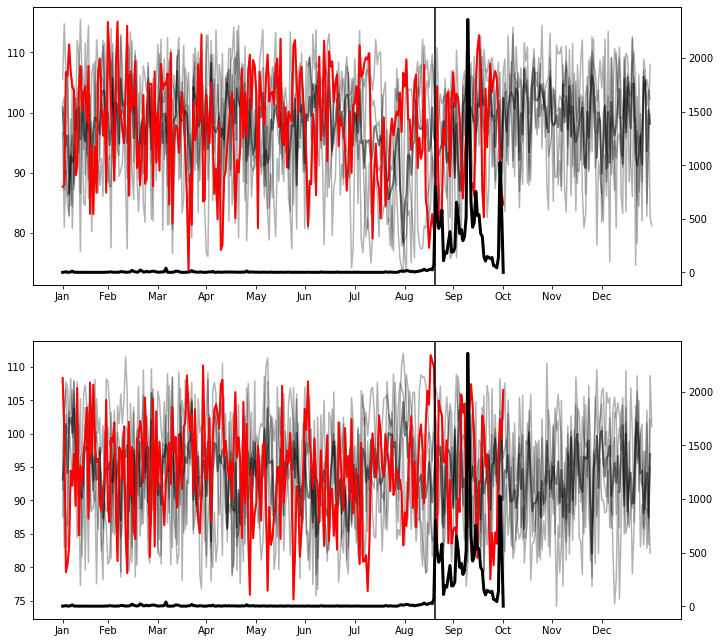

In [14]:
RE=4
print(DW_Regions[RE])
ddY = ((IFS_time.year == 2020) & (IFS_time.month > 0))
EucledianDist_orig = DATA_ED[DW_Regions[RE]]['EucledianDist_orig']
MinWTs = np.argmin(EucledianDist_orig, axis=1)

fig = plt.figure(figsize=(10,EucledianDist_orig.shape[1]*5))

gs2 = gridspec.GridSpec(EucledianDist_orig.shape[1],1)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

MON = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
iMon = np.array([31,59,90,120,151,181,212,243,273,304,334,365])-31

DAYs = np.zeros((365,len(IFSYYYY),EucledianDist_orig.shape[1])); DAYs[:]=np.nan
for wt in range(EucledianDist_orig.shape[1]):
    ax = plt.subplot(gs2[wt,0])
    for yy in range(len(IFSYYYY)):
        ddY = (IFS_time.year == IFSYYYY[yy])
        plt.plot(range(np.sum(ddY)),EucledianDist_orig[ddY,wt], c='k', alpha=0.3)
        try:
            DAYs[:,yy,wt] = EucledianDist_orig[ddY,wt][:365]
        except:
            DAYs[:np.sum(ddY),yy,wt] = EucledianDist_orig[ddY,wt]
    plt.plot(range(365), np.mean(DAYs[:,:-1,wt], axis=1), c='k', alpha=0.5, lw=2)
    plt.plot(range(np.sum(ddY)),EucledianDist_orig[ddY,wt], c='r', lw=2)
    plt.xticks(iMon,MON)
    plt.axvline(x=np.sum(iMon[7])+18+1, label='SCU Lightning Complex', c='k')
    
    # Plot burned area for 2020 on 2nd Yaxis
    ax2 = ax.twinx()
    ax2.plot(range(np.sum(ddY)),FIRMSV_SRdata[ddY,RE], c='k', lw=3)
    
    


In [14]:
'/glade/campaign/mmm/c3we/prein/IFS/'+VARact+'/'+VARact+'_'+str(IFS_timeMM[mm].year)+str(IFS_timeMM[mm].month).zfill(2)+'_daymean.nc'

'/glade/campaign/mmm/c3we/prein/IFS/UV200/UV200_201601_daymean.nc'

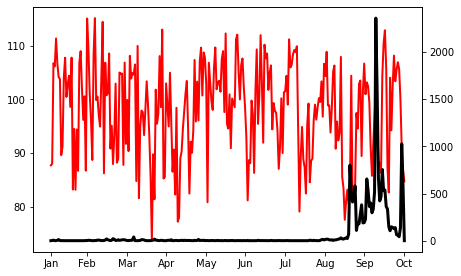

In [18]:
# fig = plt.figure(figsize=(10,5))

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

MON = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
iMon = np.array([31,59,90,120,151,181,212,243,273,304,334,365])-31
ddY = ((IFS_time.year == 2020) & (IFS_time.month > 0))

DAYs = np.zeros((365,len(IFSYYYY),EucledianDist_orig.shape[1])); DAYs[:]=np.nan
wt = 0
ax = plt.subplot(gs2[0,0])


plt.plot(range(365), np.mean(DAYs[:,:-1,wt], axis=1), c='k', alpha=0.5, lw=2)
plt.plot(range(np.sum(ddY)),EucledianDist_orig[ddY,wt], c='r', lw=2)
plt.xticks(iMon,MON)

# Plot burned area for 2020 on 2nd Yaxis
ax2 = ax.twinx()
ax2.plot(range(np.sum(ddY)),FIRMSV_SRdata[ddY,RE], c='k', lw=3)
plt.show()

In [28]:
for RE in range(len(DW_Regions)):
    print(print(DW_Regions[RE]))
    for yy in range(len(IFSYYYY)):
        ddY = ((IFS_time.year == IFSYYYY[yy]) & (IFS_time.month > 0))
        TOP = np.argsort(FIRMSV_SRdata[ddY,RE])[-1:]
        Ratio = (np.nansum(FIRMSV_SRdata[ddY,RE][TOP])/np.nansum(FIRMSV_SRdata[ddY,RE]))*100
        print('    '+str(IFSYYYY[yy])+' '+str(np.round(Ratio,1)))


Bay_Area
None
    2016 5.4
    2017 29.2
    2018 14.9
    2019 13.2
    2020 33.0
Central_Coast
None
    2016 5.0
    2017 23.1
    2018 19.0
    2019 5.1
    2020 20.9
LA
None
    2016 16.4
    2017 15.7
    2018 12.4
    2019 3.6
    2020 7.9
Modoc
None
    2016 13.4
    2017 25.1
    2018 14.6
    2019 25.8
    2020 19.9
Northeast
None
    2016 5.3
    2017 9.5
    2018 6.5
    2019 11.4
    2020 12.3
San_Diego
None
    2016 27.2
    2017 7.4
    2018 16.2
    2019 16.5
    2020 21.1
Siearas_East
None
    2016 35.3
    2017 28.8
    2018 18.7
    2019 26.7
    2020 11.2
Siearas_West
None
    2016 8.1
    2017 4.4
    2018 5.1
    2019 10.0
    2020 10.8


Modoc


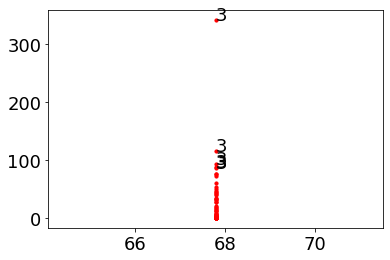

In [129]:
plt.scatter(np.min(EucledianDist_orig[ddY,:][:], axis=1), FIRMSV_SRdata[ddY,RE][:], color='r', s = 10)

TOP = np.argsort(FIRMSV_SRdata[ddY,RE][:])[-5:]
for to in range(len(TOP)):
    plt.text(np.min(EucledianDist_orig[ddY,:], axis=1)[TOP[to]], FIRMSV_SRdata[ddY,RE][:][TOP[to]], str(MinWTs[ddY][TOP[to]]+1))


# plt.scatter(np.min(EucledianDist_orig[ddY,:][1:], axis=1), FIRMSV_SRdata[ddY,RE][:-1], color='k', s = 10)
# plt.scatter(np.min(EucledianDist_orig[ddY,:][:-1], axis=1), FIRMSV_SRdata[ddY,RE][1:])

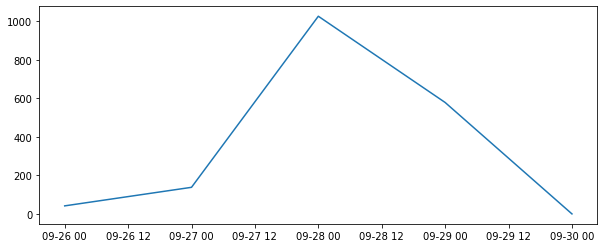

In [19]:
fig = plt.figure(figsize=(10,4))
plt.plot(IFS_time[-5:],FIRMSV_SRdata[-5:,RE])

In [122]:
RE

0

### Plot the XWT centroids in ERA5 and ERA-20C

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
rgsLableABC=list(string.ascii_lowercase)

WTSEL=1
SEL = np.argsort(EucledianDist_orig, axis=0)[0,WTSEL]
print('selected day is '+str(IFS_time[SEL]))

gs2 = gridspec.GridSpec(2,3)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

m = Basemap(projection='cea',\
            llcrnrlat= np.min(IFSLat2D) ,urcrnrlat=np.max(IFSLat2D),\
            llcrnrlon=np.min(IFSLon2D),urcrnrlon=np.max(IFSLon2D),resolution='l', fix_aspect=False)
xi, yi = m(XWTlon,XWTlat)
for va in range(3):
    ax = plt.subplot(gs2[0,va])
    cs1= plt.contourf(xi, yi, Clusters[WTSEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va]+') '+SelVar[re][va])
    if va == 0:
        ax.text(-0.07,0.5, 'ERA5' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20) #, weight='bold')
    
# XWT days in ERA-20C
xi, yi = m(XWTlon,XWTlat) #IFSLon2D,IFSLat2D)
NORMED = RemappedIFS-np.mean(RemappedIFS, axis=(1,2))[:,None,None,:]
NORMED = NORMED/np.std(NORMED, axis=(1,2))[:,None,None,:]
for va in range(3):
    ax = plt.subplot(gs2[1,va])
    cs1= plt.contourf(xi, yi, NORMED[SEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va+6]+') ')
    if va == 0:
        ax.text(-0.07,0.5, 'IFS\nmost similar XWT' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20) #, weight='bold')
        
# # add colorbar for centroids
# CbarAx = axes([0.025, 0.04, 0.95, 0.02])
# cb = colorbar(cs1, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))
# cb.ax.tick_params(labelsize=14)
# cb.ax.set_title('normalized centroids []', fontsize=14)

sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'Example_IFS-XWT'+str(WTSEL)+'-'+DW_Regions[re]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Plot the Synoptic situation for target days

        Plot map to: /glade/u/home/prein/papers/Extreme-WTs-US/plots/IFS_XWTs/IFS_large-scale-pattern_Bay_Area-2020-09-28.pdf


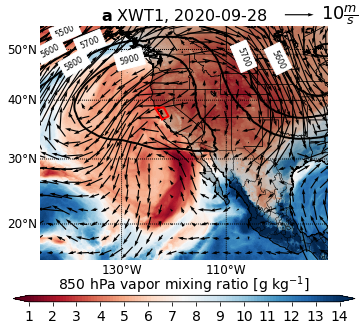

In [126]:
# Read IFS data directly
rgsWTvarsN=['U850','V850','RH2','Q850','T2AVG','Z500']

DAYS = pd.date_range(datetime.datetime(2020, 9, 28), end=datetime.datetime(2020, 9, 28), freq='d')
RE=0

sf = shp.Reader(sSubregionPR+DW_Regions[RE])
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)



for dd in range(len(DAYS)):
    TargetDay = DAYS[dd]

    DataDirPL = '/gpfs/fs1/collections/rda/data/ds113.1/ec.oper.an.pl/'
    VarsPL = [['V','132_v','V',"850"],
              ['U','131_u','U',"850"],
              ['Q','133_q','Q',"850"],
              ['Z','129_z',"Z","500"]]

    Plevs=['850','500'] #,'200']
    HH = ['00','06','12','18']
    FocusReg = [60,360-86,10,360-150]

    # ________________________________________________________________________
    # ________________________________________________________________________
    #              READ IN THE COORDINATES
    ncid=Dataset('/gpfs/fs1/collections/rda/data/ds113.1/ec.oper.an.pl/202008/ec.oper.an.pl.128_133_q.regn1280sc.2020082418.nc', mode='r')
    rgrLat=np.squeeze(ncid.variables['latitude'][:])
    rgrLon=np.squeeze(ncid.variables['longitude'][:])
    Plev = np.squeeze(ncid.variables['level'][:])
    ncid.close()

    # Find region of interest
    NN = np.where(rgrLat >= FocusReg[0])[0][-1]
    EE = np.where(rgrLon >= FocusReg[1])[0][0]
    SS = np.where(rgrLat <= FocusReg[2])[0][0]
    WW = np.where(rgrLon <= FocusReg[3])[0][-1]

    LAT = rgrLat[NN:SS]
    LON = rgrLon[WW:EE]

    iPL = np.array([np.where(Plev == int(Plevs[pl]))[0][0] for pl in range(len(Plevs))])

    LON[LON>180]=LON[LON>180]-360
    LON2D, LAT2D = np.meshgrid(LON, LAT)

#     DATA = np.zeros((len(LAT), len(LON), len(VarsPL), len(HH))); DATA[:]=np.nan
#     for sl in range(len(VarsPL)):
#         print('    process '+str(VarsPL[sl][0]))
#         sYYYYMM = str(TargetDay.year)+str(TargetDay.month).zfill(2)
#         sYYYYMMDD = str(TargetDay.year)+str(TargetDay.month).zfill(2)+str(TargetDay.day).zfill(2)
#         print('            '+sYYYYMMDD)
#         for hh in range(len(HH)):
#             PLact = np.where(Plev == int(VarsPL[sl][3]))[0][0] 
#             if ((VarsPL[sl][0] != 'U') & (VarsPL[sl][0] != 'V')):
#                 DATAfile = DataDirPL+sYYYYMM+'/ec.oper.an.pl.128_'+VarsPL[sl][1]+'.regn1280sc.'+sYYYYMMDD+HH[hh]+'.nc'
#             else:
#                 DATAfile = DataDirPL+sYYYYMM+'/ec.oper.an.pl.128_'+VarsPL[sl][1]+'.regn1280uv.'+sYYYYMMDD+HH[hh]+'.nc'
#             ncid=Dataset(DATAfile, mode='r')
#             DATA[:,:,sl,hh] = np.squeeze(ncid.variables[VarsPL[sl][2]][:,PLact,NN:SS,WW:EE])
#             ncid.close()


    # Calculate the geometry of the plot dependent on how many panels there are
    PanWidth=4 # cm
    PanHeight=2.5 # cm
    xdist=0.5
    ydist=0.5
    Panels=1
    iColums=np.min([4,Panels])
    iRows=1
    iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
    iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

    X_Fig=PanWidth*iColums+xdist*(iColums+1)
    Y_Fig=PanHeight*iRows+(iRows+1)


    plt.rcParams.update({'font.size': 18})
    rgsLableABC=list(string.ascii_lowercase)
    fig = plt.figure(figsize=(X_Fig,Y_Fig))
    gs1 = gridspec.GridSpec(iRows,iColums)
    gs1.update(left=0.10, right=0.90,
               bottom=0.20, top=0.92,
               wspace=0.05, hspace=0.20)
    # rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
    dLat=((52-25)/2.)*1.5
    dLon=(130-75)/2.
    rllcrnrlat=np.mean((LAT2D.min(),LAT2D.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
    urcrnrlat=np.mean((LAT2D.min(),LAT2D.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
    llcrnrlon=np.mean((LON2D.min(),LON2D.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
    urcrnrlon=np.mean((LON2D.min(),LON2D.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
    for pa in [0]:
        # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
        ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
        m = Basemap(projection='cea',\
                        llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                        llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
        plt.axis('off')
        xi, yi = m(LON2D, LAT2D)
        rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

        # plot IVT
        biasContDist=10
        iContNr=len(rgrColorTable)+1
        clevs=np.linspace(1, 14,100) # np.linspace(1, 14,200)
        rgrDataAct= np.mean(DATA[:,:,2,:], axis=2)*1000 #      DATA[:,:,rgsWTvarsN.index('Q850')]*1000
        cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
        # plot wind field
        iLev=1; iDist=30
        Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],
                       np.mean(DATA[::iDist,::iDist,1,:], axis=2),
                       np.mean(DATA[::iDist,::iDist,0,:], axis=2),
                       units='width',zorder = 2, pivot='middle',width=0.004, scale=100)
        if pa == 0:
            qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
        # Plot ZG500
        clevs=np.arange(0,10000,100)
        CS=m.contour(xi[:,:],yi[:,:],
                     np.mean(DATA[:,:,3,:], axis=2)/9.81,
                     levels=clevs.astype('int'),
                     colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
        clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
        [txt.set_backgroundcolor('white') for txt in clabels]

        # Lable the map
        plt.title(r"$\bf{" + str(rgsLableABC[pa]) + "}$"' XWT'+str(pa+1)+', '+str(TargetDay)[:10], fontsize=16)

        m.drawcoastlines(color='k')
        m.drawcountries(color='k')
        m.drawstates(color='k')
        m.fillcontinents(color='k',lake_color='white', alpha=0.2)
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        m.plot(XX,YY, c='r', lw=2)

        if pa == 0:
            parallels = np.arange(0.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
            meridians = np.arange(10.,351.,20.)
            m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # add colorbar for IVT
    CbarAx = axes([0.025, 0.07, 0.95, 0.02])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(1,21,1))
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_title('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=14)


    sPlotFile=sPlotDir
    # sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
    sPlotName= 'IFS_large-scale-pattern_'+DW_Regions[pa]+'-'+str(TargetDay)[:10]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print('        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName)
    

In [21]:
DATA[:,:,pl,hh].shape

(713, 911, 4)

In [22]:
DATA.shape

(713, 911, 4, 2, 4)